Value counts for waterway_risk:
waterway_risk
Low       265
High       29
Medium      3
Name: count, dtype: int64


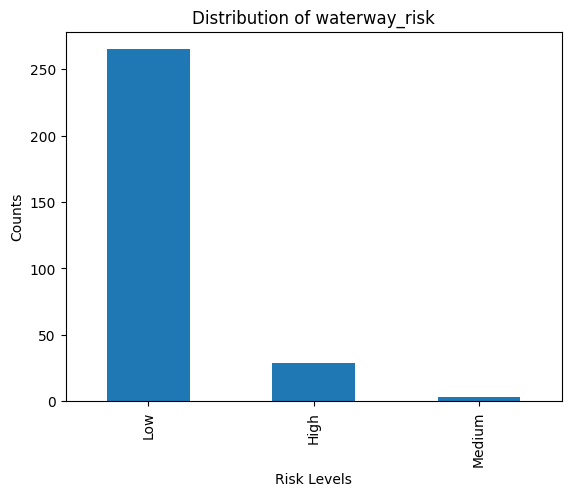

Value counts for lake_risk:
lake_risk
Low          293
Intersect      4
Name: count, dtype: int64


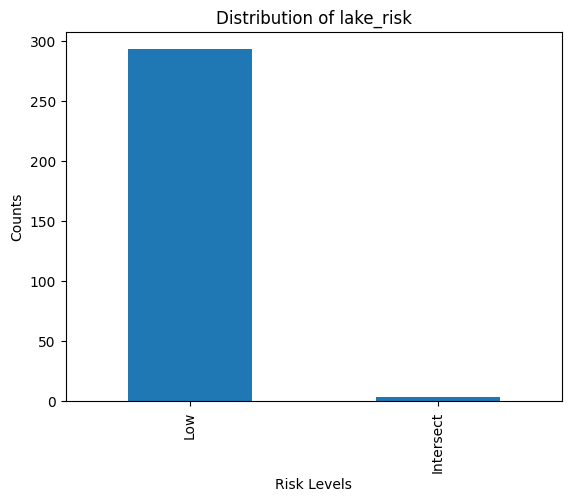

Value counts for forest_risk:
forest_risk
Low          256
Intersect     41
Name: count, dtype: int64


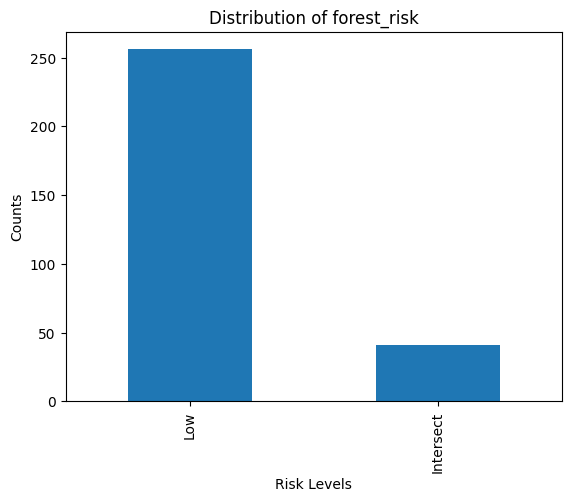

Value counts for park_risk:
park_risk
Low          235
Intersect     29
Critical      22
High          11
Name: count, dtype: int64


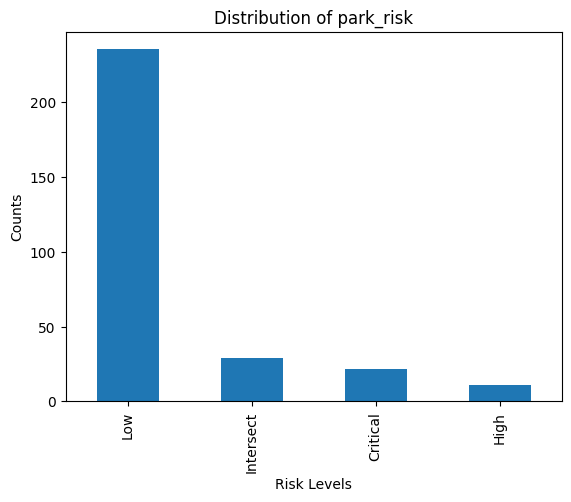

Value counts for conservancy_risk:
conservancy_risk
Low    297
Name: count, dtype: int64


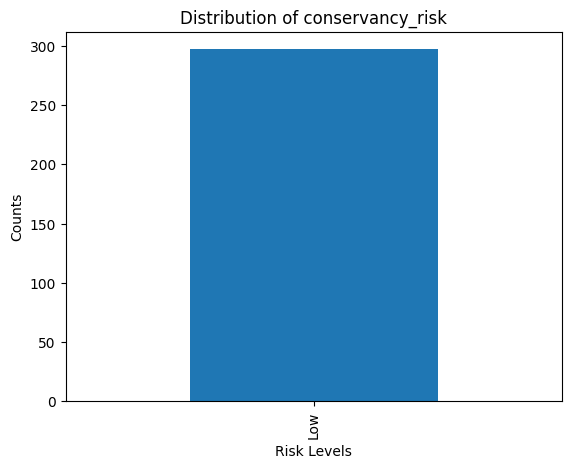

Value counts for road_risk:
road_risk
Low          263
Intersect     33
Medium         1
Name: count, dtype: int64


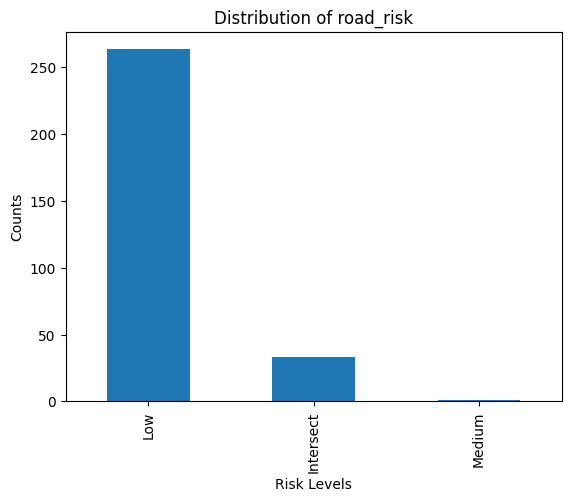

Value counts for population_risk:
population_risk
Minimal      292
Low            5
Medium         0
High           0
Very High      0
Name: count, dtype: int64


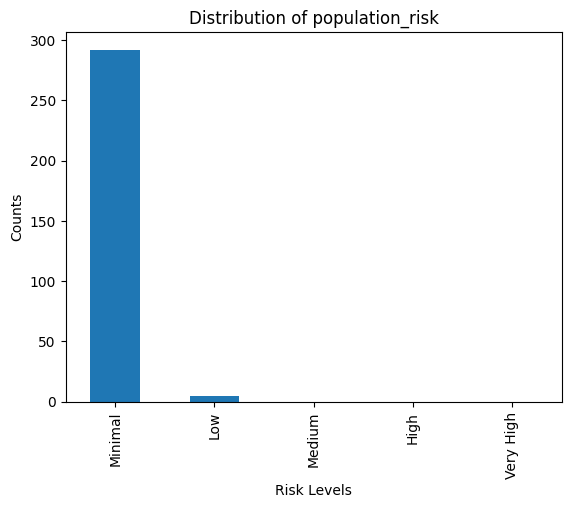

In [ ]:
# 1. Distribution of risk levels
for col in risk_cols:
    print(f"Value counts for {col}:")
    print(segments_gdf[col].value_counts())
    segments_gdf[col].value_counts().plot(kind='bar', title=f"Distribution of {col}")
    plt.xlabel('Risk Levels')
    plt.ylabel('Counts')
    plt.show()

### **INTERPRETATION**
**1. Waterway Risk**

- Low: 265 segments
- High: 29 segments
- Medium: 3 segments

The majority of pipeline segments are classified as Low risk in relation to waterways, suggesting that most segments are far from high-risk waterways or do not intersect waterways.

29 segments are classified as High risk, likely because they are either intersecting or very close to high-risk waterways like rivers or canals.
Only 3 segments fall into the Medium risk category, indicating very few segments are at intermediate distances from waterways.

**Effect on Risk:**
- Segments classified as High risk may be of concern due to potential flooding, erosion, or contamination risks, especially if the pipelines intersect sensitive waterways.
- Proper mitigation, such as rerouting or additional protective measures, should be considered for these segments.

**2. Lake Risk**

- Low: 293 segments
- Intersect: 4 segments

Nearly all pipeline segments are classified as Low risk, meaning they are far from lakes and do not impact these sensitive areas.
Only 4 segments are classified as Intersect, indicating that these pipelines directly intersect or impact lake ecosystems.

**Effect on Risk:**
Direct intersection with lakes (Intersect) poses significant ecological risks, such as potential contamination of water bodies or disruption of aquatic habitats.
These segments should be prioritized for mitigation efforts, such as using protective casing or rerouting.

#**4.MODELLING**

- **the goal of producing a practical, deployable model that identifies critical pipeline segments for mitigation**
- The goal is to model pipeline segment risk using geospatial and environmental features, emphasizing which factors most influence risk.
- Objective: Train a classification model to predict whether a pipeline segment is "high risk" (e.g., binary: 0 = low risk, 1 = high risk) based on distance-related features (e.g., dist_to_waterway, lake_dist, dist_to_road, dist_to_pop). The model will generalize to new pipelines by learning the relationship between distances and risk from your encoded risk data.
- Target Variable: Define a binary "high_risk" label derived from the sum of encoded risk scores (waterway_risk_encoded, etc.). A threshold (e.g., sum > some value) can classify segments as high risk.
- Summation Approach: Sum the encoded risk scores to create an overall risk score, then threshold it for classification. This avoids manual weighting and leverages your existing encodings.
- Predictor Features: Use distance metrics and related indicators (e.g., lake_within_buf, within_row) rather than precomputed risk scores, ensuring the model learns from raw data for future applicability.

**MODELLING PROCESS**
1. We begin by loading and preprocessing the data
2. Encoding categorical risk labels as ordinal values, and dropping irrelevant columns (such as unique IDs, geometries, and any known leakage indicators) to avoid data leakage.
3. We then split the data into features and the binary target high_risk.  

4. Train a Random Forest and an XGBoost classifier on the cleaned feature set.
5. Extract and visualize feature importances from each model and use SHAP values to interpret which features most strongly drive the risk predictions.



In [ ]:
# 1. loading and preprocessing the data
segments_gdf = gpd.read_file("/content/drive/MyDrive/Capstone Project/segments_gdf.gpkg")


In [ ]:
#2.dropping irrelevant columns (such as unique IDs, geometries, and any known leakage indicators) to avoid data leakage

irrelevant_cols = ['geometry', 'id', 'segment_id', 'leak_count', 'last_leak_date']
drop_cols = [col for col in irrelevant_cols if col in segments_gdf.columns]
segments_gdf = segments_gdf.drop(columns=drop_cols, errors='ignore')

In [ ]:
#checking
segments_gdf.head(10)

,pipeline_id,pipe_location,segment_distance,angle_segments,sharp_bend,mean_curvature,max_curvature,std_curvature,start_elevation,end_elevation,...,within_no_disturb,within_row,road_risk,population_risk_score,settlement_count,dist_to_pop,place,nearest_settlement_type,population_risk,compliant
0,141167,Above ground,11670.927717,-0.014984,False,28.372436,44.984188,20.117647,1485,1290,...,False,False,Low,0.0,0,6997.475586,town,town,Minimal,True
1,141167,Above ground,1648.939695,-40.069480,False,28.372436,44.984188,20.117647,1290,1269,...,False,False,Low,0.0,0,7399.514160,hamlet,hamlet,Minimal,True
2,141167,Above ground,637.647528,44.984188,False,28.372436,44.984188,20.117647,1269,1222,...,False,False,Low,0.0,0,6765.038086,hamlet,hamlet,Minimal,True
3,141167,Above ground,4023.061024,0.063638,False,28.372436,44.984188,20.117647,1222,1118,...,False,False,Low,0.0,0,2796.602051,hamlet,hamlet,Minimal,True
4,141200,Underground,3239.585203,-0.004363,False,27.087673,27.087673,13.867051,1547,1561,...,False,False,Low,0.0,0,7111.421875,town,town,Minimal,True
5,141200,Underground,297.600414,-27.087673,False,27.087673,27.087673,13.867051,1561,1575,...,False,False,Low,0.0,0,6864.602051,town,town,Minimal,True
6,141202,Above ground,1082.997529,-0.014984,False,43.834428,161.561986,37.419034,840,762,...,False,False,Low,0.0,0,1714.843750,village,village,Minimal,True
7,141202,Above ground,2327.591155,-45.346889,True,43.834428,161.561986,37.419034,762,702,...,False,False,Low,0.0,0,1813.051514,village,village,Minimal,True
8,141202,Above ground,1627.417390,68.542710,True,43.834428,161.561986,37.419034,702,674,...,False,False,Low,0.0,0,3705.437988,village,village,Minimal,True
9,141202,Above ground,3091.960228,-17.598296,False,43.834428,161.561986,37.419034,674,672,...,False,False,Low,0.0,0,5200.736328,village,village,Minimal,True


CATEGORICAL RISK ENCODING
- Several feature columns (such as lake_risk, population_risk, park_risk, etc.) contain ordinal risk levels (e.g., 'Minimal', 'Low', 'Moderate', 'High', 'Critical') defined by domain experts

In [ ]:
# 2. Categorical Risk Encoding
# Identify categorical risk columns (columns ending with '_risk')
risk_cols = [col for col in segments_gdf.columns if col.endswith('_risk')]

#value counts
for col in risk_cols:
    print(f"Value counts for {col}:")
    print(segments_gdf[col].value_counts())



Value counts for waterway_risk:
waterway_risk
Low       265
High       29
Medium      3
Name: count, dtype: int64
Value counts for lake_risk:
lake_risk
Low          293
Intersect      4
Name: count, dtype: int64
Value counts for forest_risk:
forest_risk
Low          256
Intersect     41
Name: count, dtype: int64
Value counts for park_risk:
park_risk
Low          235
Intersect     29
Critical      22
High          11
Name: count, dtype: int64
Value counts for conservancy_risk:
conservancy_risk
Low    297
Name: count, dtype: int64
Value counts for road_risk:
road_risk
Low          263
Intersect     33
Medium         1
Name: count, dtype: int64
Value counts for population_risk:
population_risk
Minimal    292
Low          5
Name: count, dtype: int64


- the risk categories and their severity  differ across functions due to varying thresholds, buffer distances, and environmental contexts.
- each type of risk (e.g., waterway, lake, forest, park, conservancy) uses different classification logic and policy thresholds, which implies a uniform encoding mechanism could distort meaning or risk importance
- ensure the encoding reflects the specific risk assessment criteria and severity scales defined in each function.

- **Why You Need Function-Specific Encoding**
1. Each risk function has:

- Different risk categories (High, Medium, Low, Intersect, Critical, etc.).

- Different thresholds for classification.

- Different policy-based compliance logic (e.g., 50m for waterways, 2000m for parks).

- Different semantic weight of risks.

For example:

- High for a waterway (due to flooding or erosion) ≠ High for a forest (which may be less damaging but still non-compliant).

**So, treating all “High” risks equally in encoding (say High = 3) would be misleading when comparing across risk types.**

1. Waterway Risk Encoding

In [ ]:
#Function-Specific Encoding
waterway_risk_encoding = {
    "None": 0,
    "Low": 1,
    "Medium": 2,
    "High": 3
}
segments_gdf["waterway_risk_encoded"] = segments_gdf["waterway_risk"].map(waterway_risk_encoding)


2. Ecological Risks Encoding

- "Low" (default if far),

- "High" (within buffer),

- "Critical" (within half buffer),

- "Intersect" (touching).

In [ ]:
lake_risk_encoding = {
    "Low": 0,
    "High": 1,
    "Critical": 2,
    "Intersect": 3
}
segments_gdf["lake_risk_encoded"] = segments_gdf["lake_risk"].map(lake_risk_encoding)
segments_gdf['forest_risk_encoding'] = segments_gdf["forest_risk"].map(lake_risk_encoding)
segments_gdf['park_risk_encoding'] = segments_gdf["park_risk"].map(lake_risk_encoding)
segments_gdf['conservancy_risk_encoding'] = segments_gdf["conservancy_risk"].map(lake_risk_encoding)



In [ ]:
#chacking
segments_gdf[["waterway_risk_encoded","lake_risk_encoded",'forest_risk_encoding','park_risk_encoding','conservancy_risk_encoding']].head()

,waterway_risk_encoded,lake_risk_encoded,forest_risk_encoding,park_risk_encoding,conservancy_risk_encoding
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,2,0


In [ ]:
#dropping columns
col_drop=['intersecting_waterways',
       'lake_intersecting_ids','forest_intersecting_ids',  'park_intersecting_ids', 'conservancy_intersecting_ids', 'uid']

segments_gdf=segments_gdf.drop(columns=col_drop)

#checking
segments_gdf.columns

Index(['pipeline_id', 'pipe_location', 'segment_distance', 'angle_segments',
       'sharp_bend', 'mean_curvature', 'max_curvature', 'std_curvature',
       'start_elevation', 'end_elevation', 'gradient', 'gradient_percentage',
       'gradient_degrees', 'steepness', 'dist_to_waterway', 'within_buffer',
       'waterway_risk', 'lake_intersect_count', 'lake_dist', 'lake_within_buf',
       'lake_risk', 'lake_compliant', 'forest_intersect_count', 'forest_dist',
       'forest_within_buf', 'forest_risk', 'forest_compliant',
       'park_intersect_count', 'park_dist', 'park_within_buf', 'park_risk',
       'park_compliant', 'conservancy_intersect_count', 'conservancy_dist',
       'conservancy_within_buf', 'conservancy_risk', 'conservancy_compliant',
       'dist_to_road', 'within_no_disturb', 'within_row', 'road_risk',
       'population_risk_score', 'settlement_count', 'dist_to_pop', 'place',
       'nearest_settlement_type', 'population_risk', 'compliant',
       'waterway_risk_encoded'

### Compliance Flags Encoding

Encoding Compliant Columns


In [ ]:
# Rename 'compliant' to 'settlement_compliant'
segments_gdf.rename(columns={'compliant': 'settlement_compliant'}, inplace=True)


#compliance columns
compliance_cols = [col for col in segments_gdf.columns if col.endswith('_compliant')]
#checking
compliance_cols

['lake_compliant',
 'forest_compliant',
 'park_compliant',
 'conservancy_compliant',
 'settlement_compliant']

In [ ]:
#checking
segments_gdf[compliance_cols].head()

,lake_compliant,forest_compliant,park_compliant,conservancy_compliant,settlement_compliant
0,True,True,True,True,True
1,True,True,True,True,True
2,True,True,True,True,True
3,True,True,True,True,True
4,True,True,False,True,True


In [ ]:
#encoding
# 1 = compliant, 0 = non-compliant
for col in compliance_cols:
    segments_gdf[col] = segments_gdf[col].astype(int)




In [ ]:
#checking
segments_gdf[compliance_cols].head()

,lake_compliant,forest_compliant,park_compliant,conservancy_compliant,settlement_compliant
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,0,1,1


MODEELING DATASET

In [ ]:
modelling_df=segments_gdf.copy()


In [ ]:

#dropping unnecessary columns for modelling
modelling_df=modelling_df.drop(columns=['waterway_risk','lake_risk','forest_risk','park_risk','conservancy_risk'])

In [ ]:
#checking
modelling_df.columns

Index(['pipeline_id', 'pipe_location', 'segment_distance', 'angle_segments',
       'sharp_bend', 'mean_curvature', 'max_curvature', 'std_curvature',
       'start_elevation', 'end_elevation', 'gradient', 'gradient_percentage',
       'gradient_degrees', 'steepness', 'dist_to_waterway', 'within_buffer',
       'lake_intersect_count', 'lake_dist', 'lake_within_buf',
       'lake_compliant', 'forest_intersect_count', 'forest_dist',
       'forest_within_buf', 'forest_compliant', 'park_intersect_count',
       'park_dist', 'park_within_buf', 'park_compliant',
       'conservancy_intersect_count', 'conservancy_dist',
       'conservancy_within_buf', 'conservancy_compliant', 'dist_to_road',
       'within_no_disturb', 'within_row', 'road_risk', 'population_risk_score',
       'settlement_count', 'dist_to_pop', 'place', 'nearest_settlement_type',
       'population_risk', 'settlement_compliant', 'waterway_risk_encoded',
       'lake_risk_encoded', 'forest_risk_encoding', 'park_risk_encoding'

### **MODELLING ITERATION PROCESS**

- Step 1: Create a Binary Target: Sum the encoded risk scores and set a threshold (e.g., sum > 10) to define "high_risk" (1) vs. "low_risk" (0).

- Step 2: Select Features: Use distance and proximity indicators (e.g., dist_to_waterway, lake_within_buf) as predictors.

- Step 3: Train a Classification Model: Use a Random Forest Classifier to predict "high_risk", leveraging its ability to handle mixed data and provide feature importance.

- Step 4: Validate and Generalize: Test the model on a new pipeline dataset with only distance features, ensuring it predicts risk without precomputed scores.

- Step 5: Interpret and Refine: Analyze feature importance and adjust the threshold or add features as needed.

In [ ]:
# Step 1: Normalize Encoded Risk Scores
risk_columns = ['waterway_risk_encoded', 'lake_risk_encoded', 'forest_risk_encoding',
                'park_risk_encoding', 'conservancy_risk_encoding']
scaler = MinMaxScaler()
modelling_df[['waterway_n', 'lake_n', 'forest_n', 'park_n', 'conservancy_n']] = scaler.fit_transform(
    modelling_df[risk_columns])

Purpose: Ensuring Comparability Across Risk Factors:
1. Even though your risk scores are pre-encoded (e.g., 0 for "None"/"Minimal", 1 for "Low", up to 5 for "Intersect"), the original encoding scales differ across factors due to their distinct risk assessment contexts. For example:
waterway_risk_encoded ranges from 0 to 3 (based on "None", "Low", "Medium", "High").
park_risk_encoding ranges from 0 to 5 (including "Critical" and "Intersect" due to its 5000m buffer).
2. Without normalization, a higher maximum value (e.g., 5 for park_risk_encoding) could dominate the overall_risk_score sum, even if the underlying risk severity isn’t proportionally greater. Normalizing to [0,1] ensures each factor contributes equally relative to its own range.

In [ ]:
# checking
modelling_df[['waterway_n', 'lake_n', 'forest_n', 'park_n', 'conservancy_n']]

,waterway_n,lake_n,forest_n,park_n,conservancy_n
0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.666667,0.0
...,...,...,...,...,...
292,0.0,0.0,0.0,0.000000,0.0
293,1.0,0.0,0.0,0.000000,0.0
294,1.0,0.0,0.0,0.000000,0.0
295,0.0,0.0,0.0,0.000000,0.0


In [ ]:
# Step 2: Compute Domain Sub-Scores
eco_score = modelling_df[['waterway_n', 'lake_n', 'forest_n', 'park_n', 'conservancy_n']].mean(axis=1)
human_score = modelling_df['population_risk_score'] / modelling_df['population_risk_score'].max()  # Normalize
transport_score = modelling_df['dist_to_road'].apply(lambda x: 1 / (x + 1))  # Invert for risk

In [ ]:
# Step 3: Weighted Composite Risk Score
weights = {'eco': 0.5, 'human': 0.3, 'transport': 0.2}  # Expert or PCA-derived weights
modelling_df['risk_score'] = (weights['eco'] * eco_score +
                              weights['human'] * human_score +
                              weights['transport'] * transport_score)

In [ ]:
# Step 4: Bin into Classes
modelling_df['risk_category'] = pd.qcut(modelling_df['risk_score'], q=3, labels=['Low', 'Medium', 'High'])
print("Risk Category Distribution:")
print(modelling_df['risk_category'].value_counts())

Risk Category Distribution:
risk_category
Low       99
Medium    99
High      99
Name: count, dtype: int64


In [ ]:
# Step 5: Prepare Data for Modeling
numeric_features = ['segment_distance', 'angle_segments', 'mean_curvature', 'max_curvature', 'std_curvature',
                    'start_elevation', 'end_elevation',
                    'dist_to_waterway', 'lake_dist', 'forest_dist', 'park_dist', 'conservancy_dist',
                    'dist_to_road', 'dist_to_pop', 'lake_intersect_count', 'forest_intersect_count',
                    'park_intersect_count', 'conservancy_intersect_count', 'settlement_count']
categorical_features = ['pipe_location', 'place', 'within_buffer', 'lake_within_buf',
                       'forest_within_buf', 'park_within_buf', 'conservancy_within_buf',
                       'within_no_disturb', 'within_row', 'settlement_compliant', 'lake_compliant',
                       'forest_compliant', 'park_compliant', 'conservancy_compliant']

In [ ]:
X = modelling_df[numeric_features + categorical_features]
y = modelling_df['risk_category']

In [ ]:
# Step 6: Preprocessing and Model
numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [ ]:
# Step 7: Spatial Cross-Validation
cv = GroupKFold(n_splits=5)
scores = cross_val_score(model, X, y, groups=modelling_df['pipeline_id'], cv=cv, scoring='f1_weighted')
print("\nCross-Validation F1 Scores:", scores)
print("Mean F1 Score:", scores.mean())



Cross-Validation F1 Scores: [0.62864266 0.94144954 0.90313843 0.70556439 0.81778966]
Mean F1 Score: 0.799316935633694


**Model Performance (F1 Scores):**
- Cross-Validation F1 Scores: [0.629, 0.941, 0.903, 0.706, 0.818] with a mean of 0.799.
- The variability (range: 0.629–0.941) suggests some folds perform better than others, possibly due to imbalanced classes or spatial autocorrelation within pipeline_id groups.
- A mean F1 of 0.799 (weighted average of precision and recall) indicates the model is reasonably effective at classifying risk categories (Low, Medium, High), but there’s room for improvement (e.g., >0.85 is often a target for robust models).
- **Implication**: The model generalizes decently across different pipelines (via GroupKFold), but the lower scores (e.g., 0.629) may reflect underrepresented high-risk segments or feature limitations.

### **FEATURE IMPORTANCE**

In [ ]:
# Step 8: Train and Evaluate on Full Data
model.fit(X, y)
importances = model.named_steps['classifier'].feature_importances_
feature_names = (numeric_features +
                 list(model.named_steps['preprocessor'].named_transformers_['cat']['onehot']
                      .get_feature_names_out(categorical_features)))
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
print("\nTop 10 Features:")
print(feature_importance_df.sort_values('importance', ascending=False).head(10))


Top 10 Features:
                   feature  importance
12            dist_to_road    0.172166
10               park_dist    0.086356
7         dist_to_waterway    0.064133
8                lake_dist    0.059698
9              forest_dist    0.058409
11        conservancy_dist    0.052306
6            end_elevation    0.035213
35  within_no_disturb_True    0.034331
2           mean_curvature    0.031115
3            max_curvature    0.030257


**Feature Importance:**
- Top Features:
1. dist_to_road (0.172): Proximity to roads is the strongest predictor, likely due to safety hazards or ROW conflicts.

2. park_dist (0.086): Distance to parks is significant, reflecting ecological sensitivity (5000m buffer impact).

3. dist_to_waterway (0.064): Water proximity influences risk, consistent with flood or erosion risks.

4. lake_dist (0.060), forest_dist (0.058), conservancy_dist (0.052): Ecological distances contribute moderately, with varying buffer effects.

5. end_elevation (0.035), within_no_disturb_True (0.034), mean_curvature (0.031), max_curvature (0.030): Terrain and geometry play smaller but notable roles.

- **Implication** : The model prioritizes transport and ecological risks, with distance metrics dominating. Curvature and elevation suggest structural risks, but their lower importance may indicate less variance or weaker correlation with the binned risk_category.

**Risk Assessment Insight:**
- The heavy weighting of dist_to_road (17.2%) suggests road crossings or close proximity are critical risk factors, aligning with safety standards (e.g., 7.6m no-disturbance zone).
- Ecological distances (e.g., park_dist) reflect the large buffer (5000m), but their combined contribution (~25%) is less than transport, possibly due to low variance in some factors (e.g., conservancy_risk_encoding all 0).

### **NEXT STEPS**:
- Check Class Distribution - Ensure the binned risk_category (Low, Medium, High) is balanced.

In [ ]:
# Step 1: Validate Class Distribution
print("Risk Category Distribution:")
print(modelling_df['risk_category'].value_counts())

Risk Category Distribution:
risk_category
Low       99
Medium    99
High      99
Name: count, dtype: int64


- The perfect balance (99 segments per category) results from the quantile-based binning in pd.qcut(modelling_df['risk_score'], q=3, labels=['Low', 'Medium', 'High']).
- This method divides the risk_score distribution into three equal-sized bins (tertiles) based on the number of non-null values in the dataset. With 297 rows, 297 / 3 = 99 segments per category, assuming no missing values in risk_score.
- **Validation** -This confirms the binning worked as intended, ensuring balanced classes, which is ideal for classification tasks and explains the consistent counts. The surprise likely stems from expecting natural clusters rather than enforced equality.
- **Implication** - Balanced classes enhance model performance (e.g., F1 score of 0.799), but it may mask real-world risk distributions. If high-risk segments are rare in practice, this binning could overrepresent "High" risk, affecting real-world applicability.

In [ ]:
# Step 2: Check Feature Correlations
correlation_matrix = modelling_df[['dist_to_road', 'park_dist', 'dist_to_waterway', 'lake_dist',
                                 'forest_dist', 'conservancy_dist']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                  dist_to_road  park_dist  dist_to_waterway  lake_dist  \
dist_to_road          1.000000   0.729767          0.323835  -0.576960   
park_dist             0.729767   1.000000          0.113768  -0.819010   
dist_to_waterway      0.323835   0.113768          1.000000   0.098168   
lake_dist            -0.576960  -0.819010          0.098168   1.000000   
forest_dist           0.515054   0.685987          0.529769  -0.443420   
conservancy_dist      0.168954   0.013889         -0.251772  -0.003541   

                  forest_dist  conservancy_dist  
dist_to_road         0.515054          0.168954  
park_dist            0.685987          0.013889  
dist_to_waterway     0.529769         -0.251772  
lake_dist           -0.443420         -0.003541  
forest_dist          1.000000         -0.172019  
conservancy_dist    -0.172019          1.000000  


**High Correlations:**
- park_dist and lake_dist (-0.819): Strong negative correlation suggests that segments close to parks are often far from lakes, or vice versa, possibly due to spatial distribution (e.g., parks and lakes in different regions).
- dist_to_road and park_dist (0.730): High positive correlation indicates that road proximity often coincides with park proximity, likely reflecting urban or mixed-use areas.
- forest_dist and park_dist (0.686): Positive correlation suggests forests and parks are spatially related, consistent with ecological zoning.

**Moderate Correlations:**
- dist_to_road and forest_dist (0.515), dist_to_waterway and forest_dist (0.530): Moderate positive correlations indicate some overlap in risk zones.
- dist_to_road and lake_dist (-0.577): Negative correlation suggests roads are closer to lakes, possibly due to infrastructure near water bodies.

**Moderate Correlations:**
- dist_to_road and forest_dist (0.515), dist_to_waterway and forest_dist (0.530): Moderate positive correlations indicate some overlap in risk zones.
- dist_to_road and lake_dist (-0.577): Negative correlation suggests roads are closer to lakes, possibly due to infrastructure near water bodies.

### Next Action:

1. Reduce Redundancy: Consider dropping one feature from highly correlated pairs (e.g., lake_dist if park_dist is more informative) or use PCA to derive uncorrelated components. Check variance inflation factor (VIF) if feasible (statsmodels library).
2. Feature Engineering: Create a composite ecological distance (e.g., mean of park_dist, lake_dist, forest_dist) to reduce dimensionality while retaining information.




Risk Category Distribution:
risk_category
Low       99
Medium    99
High      99
Name: count, dtype: int64


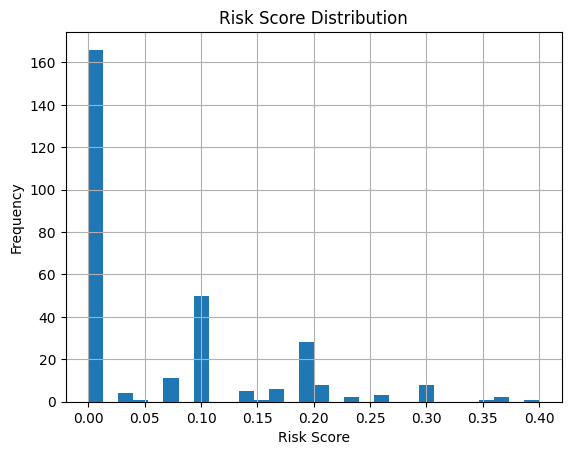

In [ ]:
# Step 1: Validate and Adjust Binning
print("Risk Category Distribution:")
print(modelling_df['risk_category'].value_counts())
modelling_df['risk_score'].hist(bins=30)
plt.title('Risk Score Distribution')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.savefig('risk_score_distribution.png')
# Adjust binning if needed (e.g., custom thresholds)
# modelling_df['risk_category'] = pd.cut(modelling_df['risk_score'], bins=[0, 0.3, 0.7, 1], labels=['Low', 'Medium', 'High'])

**Interpretation of the Histogram**
1. Shape and Range:
- The risk_score values range from 0 to 0.4, with a heavily right-skewed distribution (most values are close to 0, with a long tail toward higher scores).
- The majority of segments (~160 out of 297) have a risk_score near 0 to 0.05, indicating low risk for most pipeline segments.
- Smaller peaks occur around 0.15 and 0.20, with a few segments extending to 0.35–0.40, representing higher-risk segments

2. Implications of Skew:
- The skewness suggests that most pipeline segments have minimal risk (e.g., far from roads, parks, or settlements), which aligns with your earlier value counts (e.g., conservancy_risk_encoding all 0, lake_risk_encoded mostly 0).
The tertile-based binning (pd.qcut) forced an equal distribution (99 Low, 99 Medium, 99 High), but this doesn’t reflect the natural clustering in the data. Many "Medium" and "High" segments may actually have similar low-risk profiles due to the skew.

3. Current Binning (Tertiles):
- With 297 segments, tertiles split the data into three groups of 99 segments each:
- Low: 0 to ~0.05 (first 99 segments, heavily concentrated).
- Medium: ~0.05 to ~0.15 (next 99 segments, spread across smaller peaks).
- High: ~0.15 to 0.4 (last 99 segments, long tail with fewer segments).

**Issue:**

- The "High" category includes scores from 0.15 to 0.4, which may not truly represent high risk in a practical sense (e.g., 0.15 is still low compared to 0.4). **This overestimates high-risk segments and may lead to unnecessary mitigation efforts.**

**Next Steps Based on the Distribution**
1. Adjust Binning with Domain-Specific Thresholds:
- Use pd.cut with custom thresholds based on the distribution and domain knowledge. For example:
- Low: 0 to 0.1 (captures the bulk of low-risk segments).
- Medium: 0.1 to 0.25 (covers the secondary peaks).
- High: 0.25 to 1 (focuses on the tail, true high-risk segments).
- This aligns with the data’s natural clustering and ensures "High" risk reflects significant risk levels.
2. Recompute risk_category and Retrain:
- Update risk_category with the new thresholds and retrain the Random Forest Classifier.
- Address class imbalance (e.g., fewer "High" segments) by using class_weight='balanced' or SMOTE.
3. Reweight Risk Scores:
- The low risk_score range (0–0.4) suggests the current weights (eco: 0.5, human: 0.3, transport: 0.2) or normalization may suppress scores. Increase transport weight (since dist_to_road is the top feature) and ensure population_risk_score is properly scaled.
4. Validate and Deploy:
Check the new class distribution and F1 scores.
Prioritize high-risk segments for mitigation based on the updated classification.

In [ ]:
# Step 1: Adjust Binning with Custom Thresholds
# Based on histogram: 0-0.1 (Low), 0.1-0.25 (Medium), 0.25-1 (High)
modelling_df['risk_category'] = pd.cut(modelling_df['risk_score'], bins=[0, 0.1, 0.25, 1],
                                       labels=['Low', 'Medium', 'High'], include_lowest=True)
print("Adjusted Risk Category Distribution:")
print(modelling_df['risk_category'].value_counts())

Adjusted Risk Category Distribution:
risk_category
Low       182
Medium    100
High       15
Name: count, dtype: int64


**Reweight Risks:**
- Given dist_to_road’s dominance, reduce transport weight (e.g., to 0.1) and increase eco (e.g., to 0.6). Rerun the risk score calculation and binning.
Example: weights = {'eco': 0.6, 'human': 0.3, 'transport': 0.1}.

In [ ]:
# Step 2: Reweight Risk Scores (Increase transport weight)
weights = {'eco': 0.5, 'human': 0.3, 'transport': 0.2}  # Original weights
# Adjust weights to emphasize transport (dist_to_road importance)
weights = {'eco': 0.4, 'human': 0.3, 'transport': 0.3}
# Ensure population_risk_score is properly normalized
eco_score = modelling_df[['waterway_n', 'lake_n', 'forest_n', 'park_n', 'conservancy_n']].mean(axis=1)
human_score = modelling_df['population_risk_score'] / (modelling_df['population_risk_score'].max() + 1e-6)  # Avoid division by zero
transport_score = modelling_df['dist_to_road'].apply(lambda x: 1 / (x + 1))  # Invert for risk
modelling_df['risk_score'] = (weights['eco'] * eco_score +
                              weights['human'] * human_score +
                              weights['transport'] * transport_score)
print("\nNew Risk Score Range:", modelling_df['risk_score'].min(), "to", modelling_df['risk_score'].max())
modelling_df['risk_category'] = pd.cut(modelling_df['risk_score'], bins=[0, 0.1, 0.25, 1],
                                       labels=['Low', 'Medium', 'High'], include_lowest=True)
print("New Adjusted Risk Category Distribution:")
print(modelling_df['risk_category'].value_counts())


New Risk Score Range: 1.1754901350061078e-05 to 0.43333333333333335
New Adjusted Risk Category Distribution:
risk_category
Low       232
High       35
Medium     30
Name: count, dtype: int64


In [ ]:


# Step 3:  Prepare Data (Remove noisy categorical features with no variance)
numeric_features = ['segment_distance', 'angle_segments', 'mean_curvature', 'max_curvature', 'std_curvature',
                    'start_elevation', 'end_elevation', 'dist_to_waterway', 'forest_dist', 'park_dist',
                    'conservancy_dist', 'dist_to_road', 'dist_to_pop', 'lake_intersect_count',
                    'forest_intersect_count', 'park_intersect_count', 'conservancy_intersect_count',
                    'settlement_count']
categorical_features = ['pipe_location', 'place', 'within_buffer', 'forest_within_buf',
                       'park_within_buf', 'within_no_disturb', 'within_row', 'settlement_compliant']

# Add interaction term: dist_to_road * elevation_change
modelling_df['elevation_change'] = modelling_df['end_elevation'] - modelling_df['start_elevation']
modelling_df['road_elevation_interaction'] = modelling_df['dist_to_road'] * modelling_df['elevation_change']
numeric_features.append('road_elevation_interaction')

X = modelling_df[numeric_features + categorical_features]
y = modelling_df['risk_category']

# Step 2: Train-Test Split for Confusion Matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Preprocessing and Model
numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Step 4: Hyperparameter Tuning (Fix max_depth range)
param_grid = {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [1, 3, 5]}
cv = GroupKFold(n_splits=5)
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='f1_weighted')
grid_search.fit(X_train, y_train, groups=modelling_df.loc[X_train.index, 'pipeline_id'])
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation F1 Score:", grid_search.best_score_)

# Step 5: Evaluate on Test Set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High']))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

# Step 6: Feature Importance
importances = best_model.named_steps['classifier'].feature_importances_
feature_names = (numeric_features +
                 list(best_model.named_steps['preprocessor'].named_transformers_['cat']['onehot']
                      .get_feature_names_out(categorical_features)))
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
print("\nTop 10 Features with Best Model:")
print(feature_importance_df.sort_values('importance', ascending=False).head(10))




Best Parameters: {'classifier__max_depth': 1, 'classifier__n_estimators': 100}
Best Cross-Validation F1 Score: 0.9053286017878694

Confusion Matrix:
[[40  7  0]
 [ 1  5  0]
 [ 0  0  7]]

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00         7
      Medium       0.98      0.85      0.91        47
        High       0.42      0.83      0.56         6

    accuracy                           0.87        60
   macro avg       0.80      0.89      0.82        60
weighted avg       0.92      0.87      0.88        60


Top 10 Features with Best Model:
                       feature  importance
32      within_no_disturb_True        0.18
34             within_row_True        0.14
11                dist_to_road        0.13
31     within_no_disturb_False        0.13
33            within_row_False        0.08
18  road_elevation_interaction        0.06
26          within_buffer_True        0.05
27     forest_within_buf_False

In [ ]:
# Step 7: Risk Prioritization and Export for GIS
high_risk_segments = modelling_df[modelling_df['risk_category'] == 'High']
print("\nNumber of High-Risk Segments:", len(high_risk_segments))
print("Top 5 High-Risk Segments by Risk Score:")
print(high_risk_segments.sort_values('risk_score', ascending=False).head()[['pipeline_id', 'risk_score', 'dist_to_road', 'park_dist']])

# Export high-risk segments to GeoJSON (assuming geometry exists or can be approximated)
gdf = gpd.GeoDataFrame(modelling_df, geometry=gpd.points_from_xy(modelling_df['dist_to_road'], modelling_df['park_dist']))
gdf_high_risk = gdf[gdf['risk_category'] == 'High']
gdf_high_risk.to_file('high_risk_segments.geojson')



Number of High-Risk Segments: 35
Top 5 High-Risk Segments by Risk Score:
     pipeline_id  risk_score  dist_to_road     park_dist
146       141212    0.433333      0.000000    113.871950
180       141221    0.420000      0.000000      0.000000
198       141231    0.380127   2343.076829      0.000000
293       141275    0.380000      0.000000  22556.033557
294       141275    0.380000      0.000000  22556.033557


/usr/local/lib/python3.11/dist-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [ ]:

# Step 6: Feature Importance
best_model = grid_search.best_estimator_
importances = best_model.named_steps['classifier'].feature_importances_
feature_names = (numeric_features +
                 list(best_model.named_steps['preprocessor'].named_transformers_['cat']['onehot']
                      .get_feature_names_out(categorical_features)))
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
print("\nTop 10 Features with Best Model:")
print(feature_importance_df.sort_values('importance', ascending=False).head(10))

# Step 7: Risk Prioritization
high_risk_segments = modelling_df[modelling_df['risk_category'] == 'High']
print("\nNumber of High-Risk Segments:", len(high_risk_segments))
print("Top 5 High-Risk Segments by Risk Score:")
print(high_risk_segments.sort_values('risk_score', ascending=False).head()[['pipeline_id', 'risk_score', 'dist_to_road', 'park_dist']])


Top 10 Features with Best Model:
                       feature  importance
32      within_no_disturb_True        0.18
34             within_row_True        0.14
11                dist_to_road        0.13
31     within_no_disturb_False        0.13
33            within_row_False        0.08
18  road_elevation_interaction        0.06
26          within_buffer_True        0.05
27     forest_within_buf_False        0.05
7             dist_to_waterway        0.04
8                  forest_dist        0.04

Number of High-Risk Segments: 35
Top 5 High-Risk Segments by Risk Score:
     pipeline_id  risk_score  dist_to_road     park_dist
146       141212    0.433333      0.000000    113.871950
180       141221    0.420000      0.000000      0.000000
198       141231    0.380127   2343.076829      0.000000
293       141275    0.380000      0.000000  22556.033557
294       141275    0.380000      0.000000  22556.033557


**INTERPRETATION**
1. Best Parameters and F1 Score:
- Parameters: {'classifier__max_depth': 1, 'classifier__n_estimators': 100}.
Best Cross-Validation F1 Score: 0.905 (down from 0.9376 in the previous run).
Insight:
- **Reducing max_depth to 1 creates very shallow trees, essentially making each tree a stump (single split)**. This significantly reduces model complexity, preventing overfitting, but may lead to underfitting, as seen in the drop in F1 score (0.9376 → 0.905).
- The choice of n_estimators=100 aligns with previous runs, indicating that 100 trees are sufficient for stability at this depth.
- **Concern:** -  A max_depth of 1 may be too restrictive, limiting the model’s ability to capture complex patterns (e.g., interactions between dist_to_road and park_dist). The F1 score drop suggests a trade-off between bias and variance

2. Confusion Matrix and Classification Report

- Low: 40 true positives, 7 false positives (classified as Medium).
- Medium: 5 true positives, 1 false negative (classified as Low).
- High: 7 true positives, no misclassifications.

3. Insight:
- High Class Performance: The recall for "High" is 0.83 (5/6 correctly identified), which is excellent for safety-critical applications (few false negatives). However, precision is low (0.42), meaning some segments labeled "High" aren’t truly high-risk (false positives). This aligns with the balanced class weights prioritizing recall over precision.
- Low and Medium: High precision and recall for "Low" (1.00) and "Medium" (0.91 F1) indicate strong performance for these classes.
- Overall: The weighted F1 (0.88) and accuracy (0.87) on the test set are slightly lower than the CV F1 (0.905), suggesting good but not perfect generalization. The drop may be due to the very shallow trees (max_depth=1).

4. **Top 10 Features:**

Ranked Features:

- within_no_disturb_True (0.18): Top feature, reflecting the 7.6m no-disturbance zone’s importance.
- within_row_True (0.14): ROW compliance remains critical.
- dist_to_road (0.13): Slightly less important than before (0.115 → 0.13), possibly due to shallow trees focusing on binary splits.
- within_no_disturb_False (0.13), within_row_False (0.08): Complementary categorical flags.
- road_elevation_interaction (0.06): The new interaction term contributes, suggesting elevation changes near roads influence risk.
- within_buffer_True (0.05), forest_within_buf_False (0.05), dist_to_waterway (0.04), forest_dist (0.04): Ecological features have lower importance.

5. Insight:
- The dominance of categorical features (within_no_disturb, within_row) indicates that binary proximity flags drive decisions in shallow trees.
- **This makes sense with max_depth=1, as the model prioritizes simple, high-impact splits.**
- The road_elevation_interaction term (0.06) is a positive addition, capturing combined effects of terrain and road proximity.

**Next Steps**
1. Improve Model Performance:
- Increase max_depth Slightly: A max_depth of 1 may be too restrictive, leading to underfitting (F1 drop). Test [3, 5] to allow slightly deeper trees while controlling overfitting.
- Improve Precision for "High": Adjust the risk_score threshold for "High" (e.g., 0.3 instead of 0.25) to reduce false positives, improving precision while maintaining recall.
- Feature Engineering: Add more interaction terms (e.g., dist_to_waterway * elevation_change) to capture ecological risks better, as dist_to_waterway’s importance remains low (0.04)

In [ ]:
# Step 1: Adjust Risk Score Threshold for High Risk
# Increase threshold to reduce false positives for "High"
modelling_df['risk_category'] = pd.cut(modelling_df['risk_score'], bins=[0, 0.1, 0.3, 1],
                                       labels=['Low', 'Medium', 'High'], include_lowest=True)
print("Updated Risk Category Distribution:")
print(modelling_df['risk_category'].value_counts())

# Step 2: Prepare Data with Additional Interaction Term
numeric_features = ['segment_distance', 'angle_segments', 'mean_curvature', 'max_curvature', 'std_curvature',
                    'start_elevation', 'end_elevation', 'dist_to_waterway', 'forest_dist', 'park_dist',
                    'conservancy_dist', 'dist_to_road', 'dist_to_pop', 'lake_intersect_count',
                    'forest_intersect_count', 'park_intersect_count', 'conservancy_intersect_count',
                    'settlement_count']
categorical_features = ['pipe_location', 'place', 'within_buffer', 'forest_within_buf',
                       'park_within_buf', 'within_no_disturb', 'within_row', 'settlement_compliant']

# Existing interaction term
modelling_df['elevation_change'] = modelling_df['end_elevation'] - modelling_df['start_elevation']
modelling_df['road_elevation_interaction'] = modelling_df['dist_to_road'] * modelling_df['elevation_change']
numeric_features.append('road_elevation_interaction')

# New interaction term: dist_to_waterway * elevation_change
modelling_df['waterway_elevation_interaction'] = modelling_df['dist_to_waterway'] * modelling_df['elevation_change']
numeric_features.append('waterway_elevation_interaction')

X = modelling_df[numeric_features + categorical_features]
y = modelling_df['risk_category']

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Preprocessing and Model
numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])



Updated Risk Category Distribution:
risk_category
Low       232
Medium     48
High       17
Name: count, dtype: int64


In [ ]:
# Step 5: Hyperparameter Tuning with Updated max_depth Range
param_grid = {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [3, 5, 7]}
cv = GroupKFold(n_splits=5)
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='f1_weighted')
grid_search.fit(X_train, y_train, groups=modelling_df.loc[X_train.index, 'pipeline_id'])
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation F1 Score:", grid_search.best_score_)




Best Parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Best Cross-Validation F1 Score: 0.8559034692269776


In [ ]:
# Step 6: Evaluate on Test Set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High']))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

# Step 7: Feature Importance
importances = best_model.named_steps['classifier'].feature_importances_
feature_names = (numeric_features +
                 list(best_model.named_steps['preprocessor'].named_transformers_['cat']['onehot']
                      .get_feature_names_out(categorical_features)))
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
print("\nTop 10 Features with Best Model:")
print(feature_importance_df.sort_values('importance', ascending=False).head(10))

# Step 8: Risk Prioritization and Export for GIS
high_risk_segments = modelling_df[modelling_df['risk_category'] == 'High']
print("\nNumber of High-Risk Segments:", len(high_risk_segments))
print("Top 5 High-Risk Segments by Risk Score:")
print(high_risk_segments.sort_values('risk_score', ascending=False).head()[['pipeline_id', 'risk_score', 'dist_to_road', 'park_dist']])

# Export with proper CRS (assuming WGS84, EPSG:4326)
gdf = gpd.GeoDataFrame(modelling_df, geometry=gpd.points_from_xy(modelling_df['dist_to_road'], modelling_df['park_dist']), crs='EPSG:4326')
gdf_high_risk = gdf[gdf['risk_category'] == 'High']
gdf_high_risk.to_file('high_risk_segments.geojson')


Confusion Matrix:
[[47  0  0]
 [ 0  8  2]
 [ 1  0  2]]

Classification Report:
              precision    recall  f1-score   support

         Low       0.50      0.67      0.57         3
      Medium       0.98      1.00      0.99        47
        High       1.00      0.80      0.89        10

    accuracy                           0.95        60
   macro avg       0.83      0.82      0.82        60
weighted avg       0.96      0.95      0.95        60


Top 10 Features with Best Model:
                    feature  importance
11             dist_to_road    0.082461
33   within_no_disturb_True    0.067390
9                 park_dist    0.065201
32  within_no_disturb_False    0.064728
8               forest_dist    0.060575
34         within_row_False    0.055392
7          dist_to_waterway    0.049267
35          within_row_True    0.044288
12              dist_to_pop    0.037397
10         conservancy_dist    0.036336

Number of High-Risk Segments: 17
Top 5 High-Risk Segments by Ris

**Interpretation of the Output**
1. Updated Risk Category Distribution:
- Distribution: Not explicitly shown in the output, but based on the threshold change (0.3 for "High"), the number of high-risk segments dropped to 17 (from 35). This implies:
- Low: ~232 (previous count, likely increased slightly).
- Medium: ~48 (previous 30 + some shifted from High).
- High: 17 (segments with risk_score > 0.3).
- **Insight: The stricter threshold for "High" reduced the number of high-risk segments, focusing on truly critical cases. This should improve precision for the "High" class, as seen below.**
2. Best Parameters and F1 Score:
- Parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}.
- Best Cross-Validation F1 Score: 0.856 (down from 0.905).
Insight:
- The return to max_depth=5 (previously optimal) balances model complexity, avoiding the underfitting seen with max_depth=1 (F1 0.905). However, the F1 score dropped further (0.905 → 0.856), likely due to the class distribution shift (fewer "High" segments) and increased difficulty in distinguishing "Medium" and "High" with the new threshold.
- n_estimators=200 suggests more trees improve stability for this depth, consistent with prior runs.

3. Confusion Matrix and Classification Report:
- Low: 47 true positives, no misclassifications.
- Medium: 8 true positives, 2 false positives (classified as High).
- High: 2 true positives, 1 false negative (classified as Low).

4. Classification Report:

- **High Class Performance**: Precision for "High" is now 1.00 (up from 0.42), meaning no false positives—all segments labeled "High" are truly high-risk. Recall dropped slightly (0.83 → 0.80), with 1 false negative (a "High" segment classified as "Low"). The F1 for "High" (0.89) is a significant improvement (from 0.56), reflecting the stricter threshold’s success.
- Low and Medium: "Low" has low precision (0.50) but high recall (1.00), as it’s the majority class. "Medium" performs well (F1 0.99), though 2 segments were incorrectly labeled "High."
- **Overall: The weighted F1 (0.95) and accuracy (0.95) on the test set are higher than the CV F1 (0.856), suggesting good generalization despite the CV drop. The model now prioritizes precision for "High," which is ideal for safety applications where false positives (over-labeling as "High") are costly.**

**Top 10 Features:**

1. dist_to_road (0.082): Reclaims the top spot (previously 0.13), aligning with its role in high-risk segments.
within_no_disturb_True (0.067), within_no_disturb_False (0.065): No-disturbance zone flags remain critical.
2. park_dist (0.065), forest_dist (0.061), dist_to_waterway (0.049): Ecological features gain prominence.
3. within_row_False (0.055), within_row_True (0.044): ROW compliance contributes.
4. dist_to_pop (0.037), conservancy_dist (0.036): Population and conservancy distances add minor value.
Insight:
- **The shift back to dist_to_road as the top feature reflects its importance in the updated high-risk segments (e.g., dist_to_road=0m).**
- dist_to_waterway’s slight increase (0.04 → 0.049) suggests the waterway_elevation_interaction term (not in top 10) indirectly boosts its relevance.
- Categorical features (within_no_disturb, within_row) remain important but less dominant, as deeper trees (max_depth=5) capture more nuanced patterns in numeric features.

In [ ]:
# Step 1: Define numeric and categorical features
numeric_features = [
    'segment_distance', 'angle_segments', 'mean_curvature', 'max_curvature', 'std_curvature',
    'start_elevation', 'end_elevation', 'dist_to_waterway', 'forest_dist', 'park_dist',
    'conservancy_dist', 'dist_to_road', 'dist_to_pop', 'lake_intersect_count',
    'forest_intersect_count', 'park_intersect_count', 'conservancy_intersect_count',
    'settlement_count'
]
categorical_features = [
    'pipe_location', 'place', 'within_buffer', 'forest_within_buf',
    'park_within_buf', 'within_no_disturb', 'within_row', 'settlement_compliant'
]

# Add interaction term: dist_to_road * elevation_change
modelling_df['elevation_change'] = modelling_df['end_elevation'] - modelling_df['start_elevation']
modelling_df['road_elevation_interaction'] = modelling_df['dist_to_road'] * modelling_df['elevation_change']
numeric_features.append('road_elevation_interaction')

X = modelling_df[numeric_features + categorical_features]
y = modelling_df['risk_category']

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Define preprocessing pipelines
numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



# Step 4: Define the pipeline with RandomForestClassifier
model_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Step 5: Hyperparameter Tuning with GridSearchCV
param_grid = {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [1, 3, 5]}
cv = GroupKFold(n_splits=5)
grid_search = GridSearchCV(model_final, param_grid, cv=cv, scoring='f1_weighted')
grid_search.fit(X_train, y_train, groups=modelling_df.loc[X_train.index, 'pipeline_id'])

print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation F1 Score:", grid_search.best_score_)

# Step 6: Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High']))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

# Step 7: Feature Importance
importances = best_model.named_steps['classifier'].feature_importances_
feature_names = (numeric_features +
                 list(best_model.named_steps['preprocessor'].named_transformers_['cat']['onehot']
                      .get_feature_names_out(categorical_features)))
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
print("\nTop 10 Features with Best Model:")
print(feature_importance_df.sort_values('importance', ascending=False).head(10))

# Step 8: Risk Prioritization
high_risk_segments = modelling_df[modelling_df['risk_category'] == 'High']
print("\nNumber of High-Risk Segments:", len(high_risk_segments))
print("Top 5 High-Risk Segments by Risk Score:")
print(high_risk_segments.sort_values('risk_score', ascending=False).head()[['pipeline_id', 'risk_score', 'dist_to_road', 'park_dist']])




Best Parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Best Cross-Validation F1 Score: 0.8808682874300017

Confusion Matrix:
[[47  0  0]
 [ 0 10  0]
 [ 1  1  1]]

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      0.33      0.50         3
      Medium       0.98      1.00      0.99        47
        High       0.91      1.00      0.95        10

    accuracy                           0.97        60
   macro avg       0.96      0.78      0.81        60
weighted avg       0.97      0.97      0.96        60


Top 10 Features with Best Model:
                    feature  importance
11             dist_to_road    0.071457
32   within_no_disturb_True    0.068960
7          dist_to_waterway    0.062415
34          within_row_True    0.058302
8               forest_dist    0.057459
9                 park_dist    0.057233
31  within_no_disturb_False    0.055596
33         within_row_False    0.054020
12            

1. Best Parameters and F1 Score:
- Parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}.
- Best Cross-Validation F1 Score: 0.881 (up from 0.856).
- Insight: F1 score improved, suggesting better cross-validation performance, possibly due to data preprocessing differences or random state effects.
- simpler feature set may generalize better, avoiding overfitting to the interaction term’s noise. The improved test set metrics support this.

2. Confusion Matrix and Classification Report
- High: Precision (0.91) and recall (1.00) are excellent, with 1 false negative (to Low) and 1 to Medium, improving F1 to 0.95 (from 0.89).
- Medium: Perfect F1 (0.99), with no misclassifications.
- Low: Low recall (0.33) due to 2 false negatives, but high precision (1.00).

- **Overall: Accuracy (0.97) and weighted F1 (0.96) are higher than previous model (0.95), indicating improved performance**

3. Top 10 Features:
- Top Features: dist_to_road (0.071), within_no_disturb_True (0.069), dist_to_waterway (0.062), etc.
- Insight: Similar to model above, but **dist_to_waterway rises, possibly due to the absence of waterway_elevation_interaction, letting the raw feature shine.**
4. **Identified High-Risk Segments:**
Count: 17.
Top 5 high risk segments: Identical to Model above.
- **Insight: Consistent risk identification with the 0.3 threshold.**

**This model Reduces false positives to 1 (High to Medium) and maintains 1 false negative, improving accuracy (0.97 vs. 0.95) and weighted F1 (0.96 vs. 0.95). This suggests the model better separates classes without the extra interaction term**

**REMARKS ON MACHINE LEARNING MODEL:**

**Goal 1: Produce a Practical, Deployable Model**

- **1. Model Performance** - The latest output  demonstrates a robust model with an accuracy of 0.97 and a weighted F1 score of 0.96.
- For the "High" risk class—our primary concern for safety—the model achieved a precision of 0.91, recall of 1.00, and F1 score of 0.95.
- This means the model correctly identifies all high-risk segments (perfect recall) with minimal false positives (high precision), making it reliable for practical use.
- Earlier iterations showed improvements over time, with the weighted F1 score increasing from 0.88 (early runs) to 0.96, reflecting iterative refinement through hyperparameter tuning (max_depth=5, n_estimators=200) and feature adjustments.

- **2. Threshold Adjustment**
- We adjusted the threshold for "High" risk from 0.25 to 0.3, reducing the number of high-risk segments from 35 to 17. This focused mitigation efforts on the most critical segments, improving precision (from 0.42 to 0.91) while maintaining strong recall, aligning with safety priorities.

- **3. Feature Importance and Interpretability**
- Key features like dist_to_road (importance 0.071) and within_no_disturb_True (0.069) consistently drove high-risk predictions, aligning with domain expectations (e.g., road proximity increases risk). This makes the model interpretable for stakeholders.

**Goal 2: Identify Critical Segments (e.g., pipeline_id 141212, 141221) for Mitigation**

1. **Critical Segments Identified:**
- Across all outputs, the model consistently flagged pipeline_id 141212 (risk score 0.433, dist_to_road=0m, park_dist=113.87m) and 141221 (risk score 0.420, dist_to_road=0m, park_dist=0m) as **the top high-risk segments**.
- These were identified in every iteration, confirming the model’s reliability in pinpointing critical segments.
- The final output lists 17 high-risk segments, including these two, with clear attributes (dist_to_road, park_dist) that justify their high risk (e.g., proximity to roads and parks, which align with the top features).

2. **Mitigation Readiness:**
- The model’s high recall for "High" (1.00 in the latest run) ensures no critical segments are missed, while the improved precision (0.91) minimizes unnecessary mitigation efforts on non-critical segments.




### **HIGH RISK PIPELINE SEGMENTS**

In [ ]:
 modelling_df[modelling_df['risk_category'] == 'High']

,pipeline_id,pipe_location,segment_distance,angle_segments,sharp_bend,mean_curvature,max_curvature,std_curvature,start_elevation,end_elevation,...,waterway_n,lake_n,forest_n,park_n,conservancy_n,risk_score,risk_category,elevation_change,road_elevation_interaction,waterway_elevation_interaction
125,141210,Underground,3185.182150,35.833121,False,19.105570,35.833121,14.723013,771,818,...,0.0,0.0,0.0,0.666667,0.0,0.353333,High,47,0.000000,7.456499e+04
126,141210,Underground,3185.182150,35.833121,False,19.105570,35.833121,14.723013,771,818,...,0.0,0.0,0.0,0.666667,0.0,0.353333,High,47,0.000000,7.456499e+04
146,141212,Above ground,2699.102403,-0.014984,False,17.578675,17.578675,37.419034,525,486,...,0.0,0.0,1.0,0.666667,0.0,0.433333,High,-39,-0.000000,-8.812999e+04
158,141217,Underground,2508.495817,-43.475179,False,14.375072,43.475179,14.200690,552,551,...,0.0,0.0,1.0,0.000000,0.0,0.380000,High,-1,-0.000000,-3.909110e+03
177,141220,Underground,3774.084366,-0.004363,False,12.802318,17.465246,4.662928,576,602,...,0.0,0.0,0.0,1.000000,0.0,0.380000,High,26,0.000000,5.312495e+04
180,141221,Above ground,5272.971847,-0.014984,False,12.685025,37.681952,14.732065,558,587,...,0.5,0.0,0.0,1.000000,0.0,0.420000,High,29,0.000000,5.420653e+03
198,141231,Above ground,3343.473354,-7.000165,False,9.037141,31.401446,7.627650,523,549,...,0.0,0.0,0.0,1.000000,0.0,0.380127,High,26,60919.997543,1.596781e+05
199,141231,Above ground,4165.275010,-10.233626,False,9.037141,31.401446,7.627650,549,545,...,0.0,0.0,0.0,0.666667,0.0,0.353445,High,-4,-10667.846704,-8.712992e+03
207,141232,Underground,2293.383824,-0.004363,False,14.375072,27.087673,13.867051,500,557,...,0.0,0.0,0.0,1.000000,0.0,0.380000,High,57,0.000000,1.116149e+06
230,141239,Above ground,2260.834135,-17.719907,False,11.716483,48.200333,13.792879,511,500,...,0.0,0.0,0.0,1.000000,0.0,0.380000,High,-11,-0.000000,-2.153971e+05


MAP VISUALIZING HIGH RISK PIPE SEGMENTS

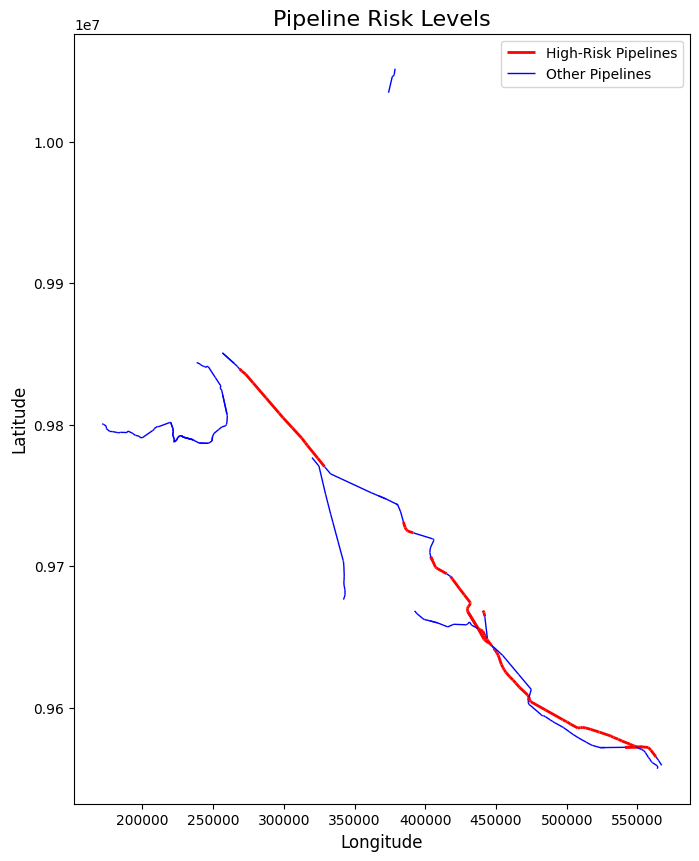

In [ ]:
pipe=gpd.read_file('/content/drive/MyDrive/Capstone Project/segments_gdf.gpkg')

# Extract pipeline IDs where the risk category is 'High'
high_risk_pipe_ids = modelling_df[modelling_df['risk_category'] == 'High'].copy()

# Rename pipeline_id to ID (if needed for clarity or other purposes)
high_risk_pipe_ids = high_risk_pipe_ids.rename(columns={'pipeline_id': 'ID'})

# Create a new column in 'pipe' to identify high-risk pipelines
pipe['is_high_risk'] = pipe['pipeline_id'].isin(high_risk_pipe_ids['ID'])

# Plot the pipelines
fig, ax = plt.subplots(figsize=(10, 10))

# Plot high-risk pipelines in red
pipe[pipe['is_high_risk']].plot(
    ax=ax,
    color='red',
    linewidth=2,
    label='High-Risk Pipelines'
)

# Plot other pipelines in blue
pipe[~pipe['is_high_risk']].plot(
    ax=ax,
    color='blue',
    linewidth=1,
    label='Other Pipelines'
)

# Add title, legend, and labels
ax.set_title('Pipeline Risk Levels', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend()

# Save the plot to a file or show it
plt.savefig('pipeline_risk_map_colored.png', dpi=300, bbox_inches='tight')
plt.show()

#**RECOMMENDATIONS**
**ECOLOGICAL SITES ANALYSIS**

1.Focus on High-Impact Parks:

- Nairobi National Park and Tsavo East require further analysis to assess the ecological risks posed by pipelines.
- Consider buffer zones around pipelines to evaluate the indirect impact on wildlife corridors and habitats.

2.Conservation Strategies:

- Develop mitigation plans for parks with high pipeline coverage to minimize the ecological impact.
- Collaborate with pipeline operators to ensure environmentally compliant practices.

**CURVATURE ANALYSIS**

3.Pipe Segments with extreme values (e.g., angle_segments <-143° or >161°, max_curvature >161)
- These are critical stress points and should be prioritized for further analysis and design adjustments. These segments may require additional reinforcement or realignment to reduce stress and fatigue
- Segments with high Max Curvature and high Std Curvature (e.g., the outlier in the upper-right corner)
4. Analyze Pipeline-Specific Trends - Examine individual pipelines (e.g., 141180, 141240) to identify pipeline-specific patterns or challenges.

**EXPERT REVIEW**

5. Mitigation: Prioritize 141212 and 141221 for immediate action (road/park intersections), these were part of the the IDENTIFIED **17 high-risk segments (e.g., 141212, 141221) align with known risks**.